#EVALUATION OF BASELINE MODELS

In [2]:
import kagglehub
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#Skin Cancer

In [3]:
# Download latest version
path_skin = kagglehub.dataset_download("hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images")

print("Path to dataset files:", path_skin)

Path to dataset files: /root/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1


In [4]:
# Replace 'directory_path' with your directory's path
directory_path = path_skin+'/melanoma_cancer_dataset'

# List all files and directories
contents = os.listdir(directory_path)
print(contents)

['test', 'train']


In [5]:
# Path to your dataset
train_path = path_skin+'/melanoma_cancer_dataset/train'
test_path = path_skin+'/melanoma_cancer_dataset/test'

# Load train dataset
train_dataset = image_dataset_from_directory(
    train_path,
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    seed=123,
    validation_split=0.2,  # 20% of data used for validation
    subset="training"      # Specify this is the training subset
)

val_dataset = image_dataset_from_directory(
    train_path,
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    seed=123,
    validation_split=0.2,  # Same split ratio
    subset="validation"    # Specify this is the validation subset
)

# Load test dataset
test_dataset = image_dataset_from_directory(
    test_path,
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    seed=123,
    shuffle=False
)

# Check class names
class_names = train_dataset.class_names
print("Class Names:", class_names)

Found 9605 files belonging to 2 classes.
Using 7684 files for training.
Found 9605 files belonging to 2 classes.
Using 1921 files for validation.
Found 1000 files belonging to 2 classes.
Class Names: ['benign', 'malignant']


In [6]:
# Save class names before applying map
class_names = train_dataset.class_names
print("Class Names:", class_names)

Class Names: ['benign', 'malignant']


In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

In [8]:
# Apply data augmentation
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

# Prefetch the datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
def build_vit_model(image_size=224, patch_size=16, num_classes=10, d_model=64, num_heads=4, mlp_dim=128, depth=8):
    # Patch embedding
    inputs = layers.Input(shape=(image_size, image_size, 3))
    patches = layers.Conv2D(d_model, patch_size, strides=patch_size, padding='valid')(inputs)
    patches = layers.Reshape((-1, d_model))(patches)  # Flatten patches

    # Add positional embeddings
    num_patches = (image_size // patch_size) ** 2
    pos_embeddings = layers.Embedding(input_dim=num_patches, output_dim=d_model)(tf.range(num_patches))
    embeddings = patches + pos_embeddings

    # Transformer encoder
    for _ in range(depth):
        # Layer normalization
        x = layers.LayerNormalization()(embeddings)
        # Multi-head self-attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = attention_output + embeddings  # Skip connection
        # Feed-forward network
        x = layers.LayerNormalization()(x)
        x_ff = layers.Dense(mlp_dim, activation='relu')(x)
        x_ff = layers.Dense(d_model)(x_ff)
        embeddings = x_ff + x  # Skip connection

    # Classification head
    x = layers.LayerNormalization()(embeddings)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)


In [10]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [12]:
model = build_vit_model(image_size=224, patch_size=16, num_classes=len(class_names), depth=2)

model.compile(
    optimizer = tf.keras.optimizers.Adam(clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 146s 459ms/step - accuracy: 0.6090 - loss: 0.6675 - val_accuracy: 0.7944 - val_loss: 0.4281
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 78s 324ms/step - accuracy: 0.7936 - loss: 0.4763 - val_accuracy: 0.8037 - val_loss: 0.4212
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 78s 324ms/step - accuracy: 0.8002 - loss: 0.4458 - val_accuracy: 0.8074 - val_loss: 0.5068
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 78s 324ms/step - accuracy: 0.8234 - loss: 0.3924 - val_accuracy: 0.8204 - val_loss: 0.4009
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 78s 324ms/step - accuracy: 0.8388 - loss: 0.3664 - val_accuracy: 0.8209 - val_loss: 0.3645
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 78s 324ms/step - accuracy: 0.8342 - loss: 0.3690 - val_accuracy: 0.8391 - val_loss: 0.3373
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 78s 325ms/step - accuracy: 0.8407 - loss: 0.3605 - val_accuracy: 0.8339 - val_loss: 0.3556
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 78s 324ms/step - accuracy: 0.8430 - loss: 

In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.8643 - loss: 0.2684
Test Accuracy: 0.87


In [14]:
model.save('skin_cancer_model.keras')

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step


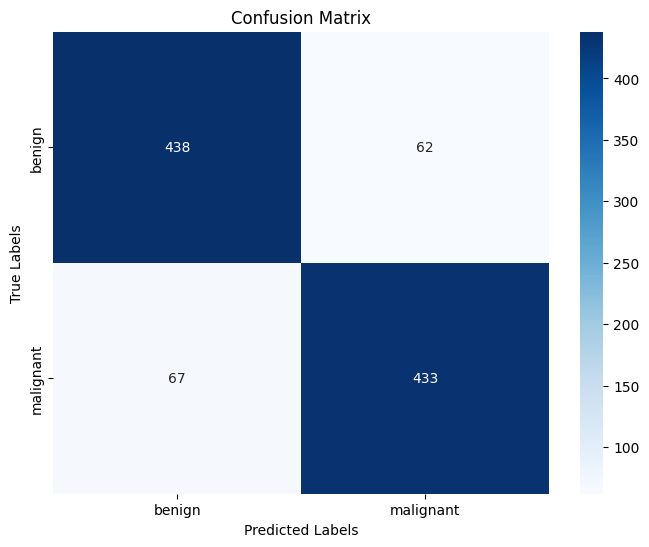

In [15]:
# 1. Predict labels for the test dataset
y_true = np.array([label.numpy() for _, label in test_dataset.unbatch()])
y_pred = np.argmax(model.predict(test_dataset), axis=1)

# 3. Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [16]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      benign       0.87      0.88      0.87       500
   malignant       0.87      0.87      0.87       500

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



#Facial Skin Diseases

In [17]:
# Download latest version
path_facial = kagglehub.dataset_download("shwetakk/facial-skin-disease")

print("Path to dataset files:", path_facial)

100%|██████████| 8.08M/8.08M [00:01<00:00, 5.56MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shwetakk/facial-skin-disease/versions/1


In [18]:
# Replace 'directory_path' with your directory's path
directory_path = path_facial+'/facial-skin-diseases'

# List all files and directories
contents = os.listdir(directory_path)
print(contents)

['test', 'train']


In [19]:
# Path to your dataset
train_path = path_facial+'/facial-skin-diseases/train'
test_path = path_facial+'/facial-skin-diseases/test'

# Load train dataset
train_dataset = image_dataset_from_directory(
    train_path,
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    seed=123,
    validation_split=0.2,  # 20% of data used for validation
    subset="training"      # Specify this is the training subset
)

val_dataset = image_dataset_from_directory(
    train_path,
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    seed=123,
    validation_split=0.2,  # Same split ratio
    subset="validation"    # Specify this is the validation subset
)

# Load test dataset
test_dataset = image_dataset_from_directory(
    test_path,
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    seed=123,
    shuffle=False
)

# Check class names
class_names = train_dataset.class_names
print("Class Names:", class_names)

Found 398 files belonging to 5 classes.
Using 319 files for training.
Found 398 files belonging to 5 classes.
Using 79 files for validation.
Found 100 files belonging to 5 classes.
Class Names: ['acne', 'eksim', 'herpes', 'panu', 'rosacea']


In [20]:
# Save class names before applying map
class_names = train_dataset.class_names
print("Class Names:", class_names)

Class Names: ['acne', 'eksim', 'herpes', 'panu', 'rosacea']


In [21]:
# Apply data augmentation
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

# Prefetch the datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [22]:
model = build_vit_model(image_size=224, patch_size=16, num_classes=len(class_names), depth=2)

model.compile(
    optimizer = tf.keras.optimizers.Adam(clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.2181 - loss: 2.1354 - val_accuracy: 0.2025 - val_loss: 1.6437
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - accuracy: 0.1811 - loss: 1.6752 - val_accuracy: 0.1646 - val_loss: 1.6146
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.1914 - loss: 1.6297 - val_accuracy: 0.2152 - val_loss: 1.6203
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.2422 - loss: 1.6333 - val_accuracy: 0.1646 - val_loss: 1.6752
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.2471 - loss: 1.6671 - val_accuracy: 0.2152 - val_loss: 1.6055
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - accuracy: 0.1797 - loss: 1.6457 - val_accuracy: 0.2025 - val_loss: 1.6199
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.2318 - loss: 1.6286 - val_accuracy: 0.1646 - val_loss: 1.6572
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.2762 - loss: 1.6036 - val_accuracy: 0.21

In [23]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 667ms/step - accuracy: 0.3099 - loss: 1.5946
Test Accuracy: 0.28


In [24]:
model.save('facial_diseases_model.keras')

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 702ms/step


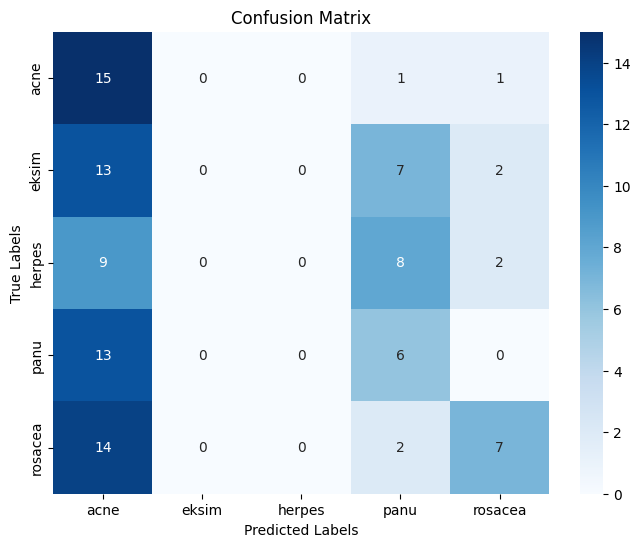

In [25]:
# 1. Predict labels for the test dataset
y_true = np.array([label.numpy() for _, label in test_dataset.unbatch()])
y_pred = np.argmax(model.predict(test_dataset), axis=1)

# 3. Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [26]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        acne       0.23      0.88      0.37        17
       eksim       0.00      0.00      0.00        22
      herpes       0.00      0.00      0.00        19
        panu       0.25      0.32      0.28        19
     rosacea       0.58      0.30      0.40        23

    accuracy                           0.28       100
   macro avg       0.21      0.30      0.21       100
weighted avg       0.22      0.28      0.21       100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Hair Diseases

In [27]:
# Download latest version
path_hair = kagglehub.dataset_download("sundarannamalai/hair-diseases")

print("Path to dataset files:", path_hair)

100%|██████████| 564M/564M [00:31<00:00, 18.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sundarannamalai/hair-diseases/versions/1


In [28]:
# Replace 'directory_path' with your directory's path
directory_path = path_hair+'/Hair Diseases - Final'

# List all files and directories
contents = os.listdir(directory_path)
print(contents)

['test', 'train', 'val']


In [29]:
# Path to your dataset
train_path = path_hair+'/Hair Diseases - Final/train'
val_path = path_hair+'/Hair Diseases - Final/val'
test_path = path_hair+'/Hair Diseases - Final/test'

# Load train dataset
train_dataset = image_dataset_from_directory(
    train_path,
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    seed=123
)

val_dataset = image_dataset_from_directory(
    val_path,
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    seed=123
)

# Load test dataset
test_dataset = image_dataset_from_directory(
    test_path,
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    seed=123,
    shuffle=False
)

# Check class names
class_names = train_dataset.class_names
print("Class Names:", class_names)

Found 9600 files belonging to 10 classes.
Found 1200 files belonging to 10 classes.
Found 1200 files belonging to 10 classes.
Class Names: ['Alopecia Areata', 'Contact Dermatitis', 'Folliculitis', 'Head Lice', 'Lichen Planus', 'Male Pattern Baldness', 'Psoriasis', 'Seborrheic Dermatitis', 'Telogen Effluvium', 'Tinea Capitis']


In [30]:
# Save class names before applying map
class_names = train_dataset.class_names
print("Class Names:", class_names)

Class Names: ['Alopecia Areata', 'Contact Dermatitis', 'Folliculitis', 'Head Lice', 'Lichen Planus', 'Male Pattern Baldness', 'Psoriasis', 'Seborrheic Dermatitis', 'Telogen Effluvium', 'Tinea Capitis']


In [31]:
# Apply data augmentation
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

# Prefetch the datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [32]:
model = build_vit_model(image_size=224, patch_size=16, num_classes=len(class_names), depth=2)

model.compile(
    optimizer = tf.keras.optimizers.Adam(clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 125s 361ms/step - accuracy: 0.1307 - loss: 2.3714 - val_accuracy: 0.2458 - val_loss: 2.0656
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 98s 327ms/step - accuracy: 0.2757 - loss: 2.0134 - val_accuracy: 0.4017 - val_loss: 1.7437
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 98s 327ms/step - accuracy: 0.3973 - loss: 1.6981 - val_accuracy: 0.4825 - val_loss: 1.4430
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 98s 327ms/step - accuracy: 0.5530 - loss: 1.2941 - val_accuracy: 0.5667 - val_loss: 1.2603
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 98s 327ms/step - accuracy: 0.6754 - loss: 0.9461 - val_accuracy: 0.7550 - val_loss: 0.7239
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 98s 327ms/step - accuracy: 0.7873 - loss: 0.6397 - val_accuracy: 0.8258 - val_loss: 0.5438
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 98s 327ms/step - accuracy: 0.8684 - loss: 0.4271 - val_accuracy: 0.8183 - val_loss: 0.5229
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 98s 327ms/step - accuracy: 0.8809 - loss: 

In [33]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9836 - loss: 0.0577
Test Accuracy: 0.97


In [34]:
model.save('hair_diseases_model.keras')

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step


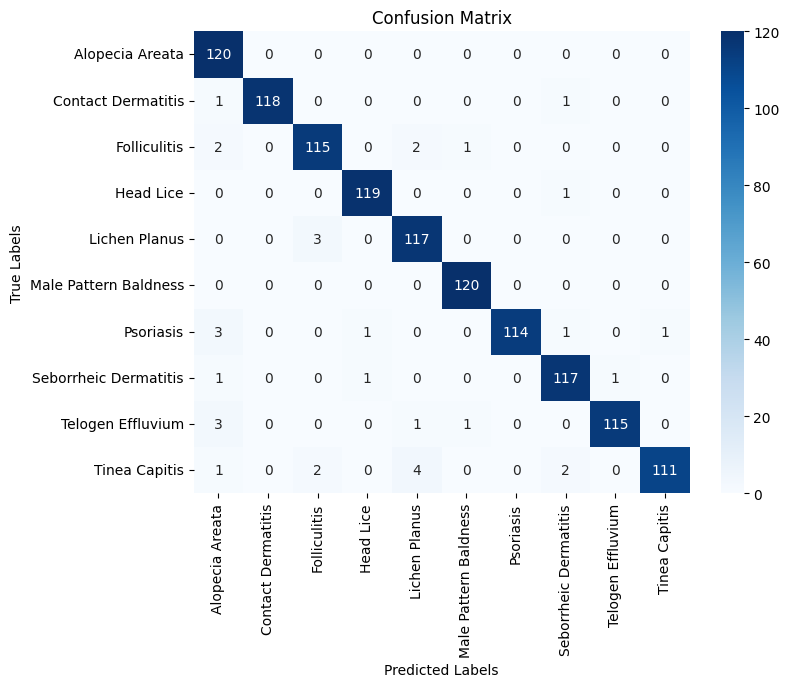

In [35]:
# 1. Predict labels for the test dataset
y_true = np.array([label.numpy() for _, label in test_dataset.unbatch()])
y_pred = np.argmax(model.predict(test_dataset), axis=1)

# 3. Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [36]:
print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

      Alopecia Areata       0.92      1.00      0.96       120
   Contact Dermatitis       1.00      0.98      0.99       120
         Folliculitis       0.96      0.96      0.96       120
            Head Lice       0.98      0.99      0.99       120
        Lichen Planus       0.94      0.97      0.96       120
Male Pattern Baldness       0.98      1.00      0.99       120
            Psoriasis       1.00      0.95      0.97       120
Seborrheic Dermatitis       0.96      0.97      0.97       120
    Telogen Effluvium       0.99      0.96      0.97       120
        Tinea Capitis       0.99      0.93      0.96       120

             accuracy                           0.97      1200
            macro avg       0.97      0.97      0.97      1200
         weighted avg       0.97      0.97      0.97      1200

